In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
!pip install -U accelerate
!pip install -U transformers
!pip install transformers[torch]
!pip install accelerate -U
!pip install rouge_score
!pip install evaluate
from transformers import AutoTokenizer
import evaluate
import torch
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 80.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.39.3
    Uninstalling transformers-4.39.3:
      Successfully uninstalled transformers-4.39.3
  Preparing metadata (setup.py) ... - done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=0bcb979fbddaadce705f41b852976233f9b241f55614a71d5f62cc0d27df7e88
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:

2024-04-27 13:37:26.011375: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 13:37:26.011479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 13:37:26.145301: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# System Used

### CPU Information:

* CPU Model: Intel(R) Xeon(R) CPU @ 2.00GHz
* Number of CPU Cores: 4



### GPU Information:

* Name: Tesla P100-PCIE-16GB
* GPU Memory Total: 16384.0 MB


### RAM (Memory) Information:

* Total Memory: 31.36 GB





# Importing Caption Data

Here we import in the caption text data for the images from the Flickr8k dataset

In [2]:
text_data = pd.read_csv('/kaggle/input/flickr8k/captions.txt', sep='|')
text_data

image_name  caption_number  \
0      1000268201_693b08cb0e.jpg               0   
1      1000268201_693b08cb0e.jpg               1   
2      1000268201_693b08cb0e.jpg               2   
3      1000268201_693b08cb0e.jpg               3   
4      1000268201_693b08cb0e.jpg               4   
...                          ...             ...   
40450   997722733_0cb5439472.jpg               0   
40451   997722733_0cb5439472.jpg               1   
40452   997722733_0cb5439472.jpg               2   
40453   997722733_0cb5439472.jpg               3   
40454   997722733_0cb5439472.jpg               5   

                                            caption_text  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451           A man is rock climbing high in the air .  
40452  A person in a red shirt climbing up a rock fac...  
40453                    A rock climber in a red shirt .  
40454  A rock climber practices on a rock climbing wa...  

[40455 rows x 3 columns]

# Data Preparation

Cleaning and filtering out images for training and validation data

In [3]:
text_data = pd.read_csv('/kaggle/input/flickr8k/captions.txt', sep='|')
text_data.rename(columns={"caption_number":"image_repeat","caption_text":"caption"},inplace=True)
text_data.drop(text_data[text_data['image_name']=="2258277193_586949ec62.jpg.1"].index, inplace=True)
text_data.reset_index(drop=True, inplace=True)

In [4]:
# Drop rows with given value of column
text_data_train = text_data.drop(text_data[text_data['image_repeat']==0].index)
text_data_train.reset_index(drop=True, inplace=True)

# text_data_train = text_data[text_data['image_repeat']==1]
# text_data_train.reset_index(drop=True, inplace=True)
text_data_val = text_data[ text_data['image_repeat']==0 ]
text_data_val.reset_index(drop=True, inplace=True)
text_data_train.shape, text_data_val.shape

((32364, 3), (8091, 3))

# Vision Encoder Decoder Models

The model consists of:
* A Vision Transformer(ViT) - Takes in patches of images as inputs and produce a sequence of output representations for each patch
* A Text Decoder Transformer - Takes in the final representation of the vision Transformer, along with input caption IDs and predict the next token in the caption for each time step, in this case we are using BERT (Bidirectional Encoder Representations from Transformers)


![Vision Encoder Decoder](https://thepythoncode.com/media/articles/image-captioning-with-pytorch-and-transformers-in-python/vision-encoder-decoder.png)

In [5]:
batch_size = 32
epochs = 40

In [6]:
from transformers import AutoImageProcessor, AutoTokenizer, VisionEncoderDecoderModel
from PIL import Image
import requests

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
decoder_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", add_special_tokens=True)

if decoder_tokenizer.pad_token is None:
    decoder_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224-in21k", "bert-base-uncased")

# ids
model.config.decoder_start_token_id = decoder_tokenizer.cls_token_id
model.config.pad_token_id = decoder_tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

In [7]:
from torch.utils.data import Dataset
# from datasets import Dataset
image_height = 224
image_width = 224

class ImageCaptionDataset(Dataset):
    def __init__(self, image_path, text_df, tokenizer, image_height,image_width):
        self.image_path = image_path
        self.text_df = text_df
        self.tokenizer = tokenizer
        self.image_height = image_height
        self.image_width = image_width
        
    def __len__(self):
        return self.text_df.shape[0]
    
    def __getitem__(self,index):
        path_filename = self.image_path + text_data_train.iloc[index]['image_name']
        image = np.array(Image.open( path_filename ).resize((self.image_width, self.image_height)), dtype=np.uint8)
        image = torch.tensor(np.moveaxis(image, -1, 0))
        caption_token = self.tokenizer( text_data_train.iloc[index]['caption'], add_special_tokens=True, padding="max_length", max_length=32, truncation = True  ).input_ids 
        caption_token = [token if token != self.tokenizer.pad_token_id else -100 for token in caption_token] 
        return {"pixel_values": image.squeeze(), "caption_token": torch.tensor(caption_token)} #, "caption":self.captions[index]}


train_dataset = ImageCaptionDataset( image_path="/kaggle/input/flickr8k/images/", text_df=text_data_train , tokenizer=decoder_tokenizer, image_height=224, image_width=224 )
val_dataset = ImageCaptionDataset( image_path="/kaggle/input/flickr8k/images/", text_df=text_data_val , tokenizer=decoder_tokenizer, image_height=224, image_width=224 )

# Understanding The Data

The data includes images with multiple caption for each of them

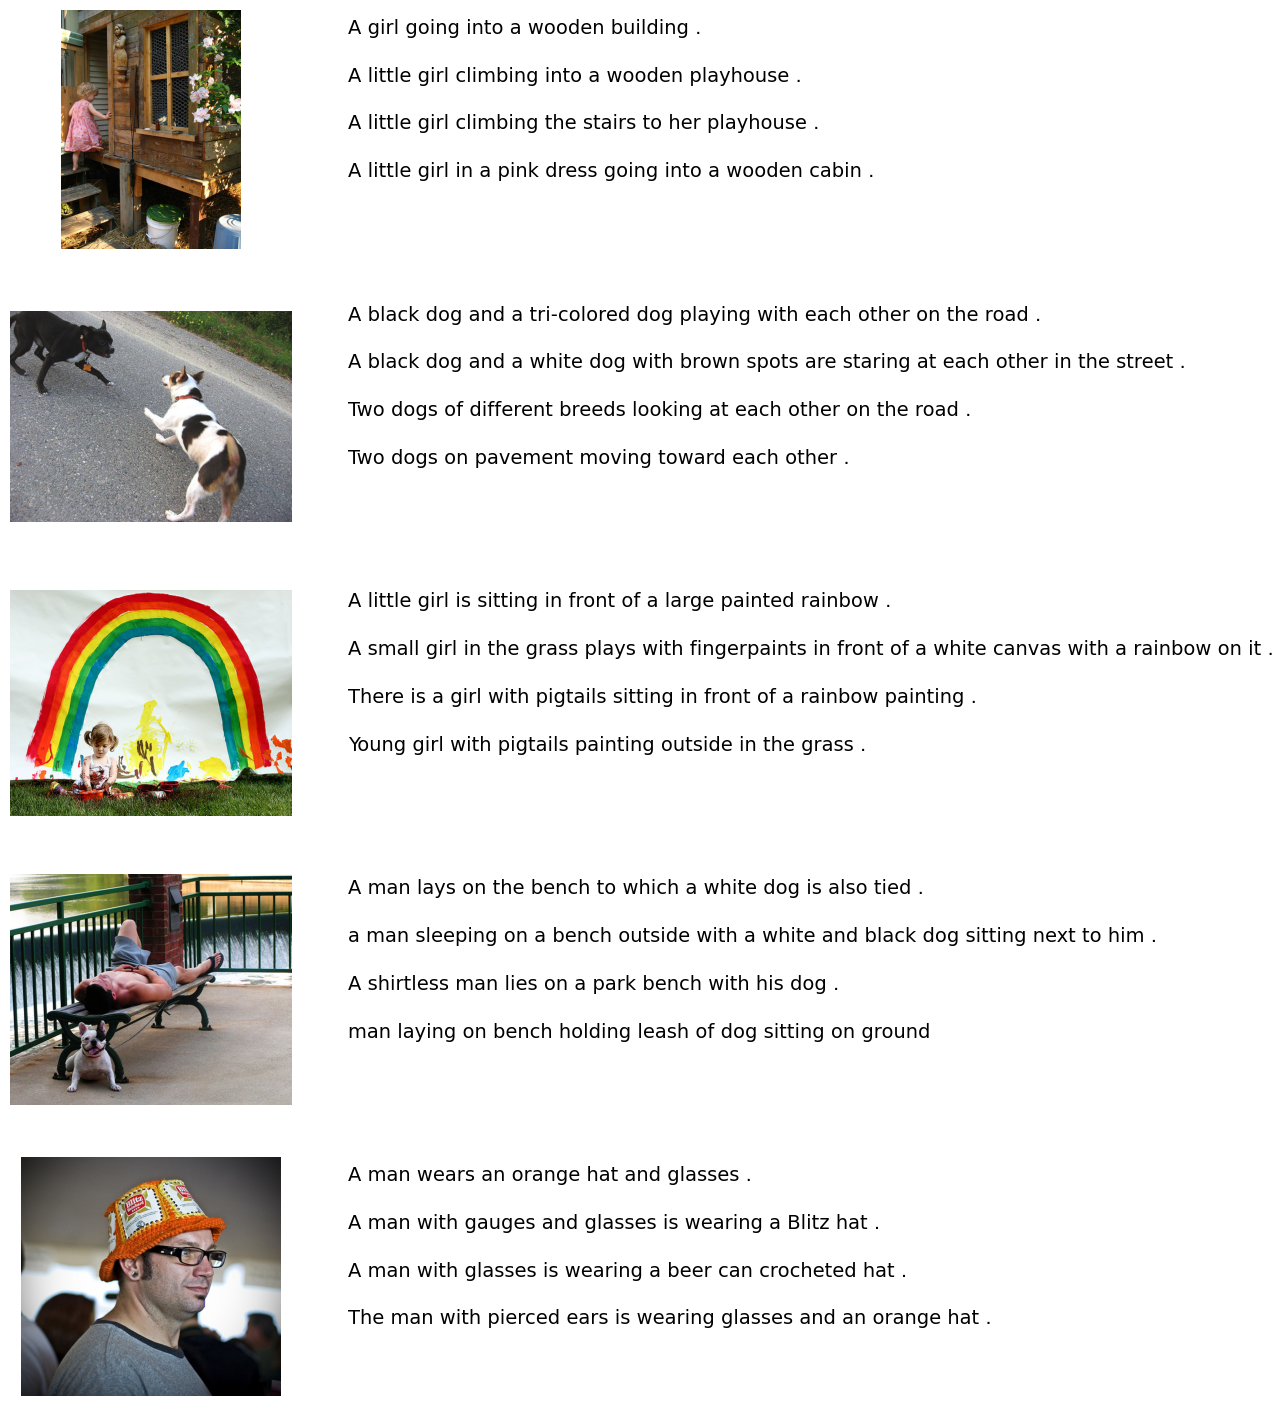

In [8]:
sample_data = text_data_train.groupby("image_name")["caption"].agg(list).iloc[:5]


fig, axes = plt.subplots(len(sample_data), 2, figsize=(8, 18))

for ax_row, image_name, captions in zip(axes, sample_data.index, sample_data):
    ax_row[0].imshow(Image.open("/kaggle/input/flickr8k/images/"+image_name))
    ax_row[0].axis("off")

    text_y = 0.9
    for caption in captions:
        ax_row[1].text(0, text_y, caption, fontsize=14)
        text_y -= 0.2
    ax_row[1].axis("off")

plt.show()

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Training Setup

In [10]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

from transformers import get_scheduler
num_training_steps = epochs * len(train_dataloader)
lr_scheduler = get_scheduler( name="linear", optimizer=optimizer, num_warmup_steps=int(num_training_steps/5), num_training_steps=num_training_steps )


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
print(device)
# Set GPU/CPU
model.to(device)

cuda


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

# Training Model

In [11]:
from tqdm.auto import tqdm
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(epochs):
    losses = []
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(pixel_values = batch['pixel_values'], labels=batch['caption_token']) # decoder_input_ids=batch['caption_token'],
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        losses.append(loss)
        
    print('Epoch: {}, Loss: {:.4f}'.format(epoch, sum(losses)))

  0%|          | 0/40480 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch: 0, Loss: 5792.0527
Epoch: 1, Loss: 3148.8877
Epoch: 2, Loss: 2791.9836
Epoch: 3, Loss: 2592.9216
Epoch: 4, Loss: 2430.3708
Epoch: 5, Loss: 2255.7639
Epoch: 6, Loss: 2080.6816
Epoch: 7, Loss: 1906.9492
Epoch: 8, Loss: 1713.9475
Epoch: 9, Loss: 1504.4517
Epoch: 10, Loss: 1311.8024
Epoch: 11, Loss: 1143.9276
Epoch: 12, Loss: 983.5361
Epoch: 13, Loss: 853.7245
Epoch: 14, Loss: 743.2438
Epoch: 15, Loss: 647.5970
Epoch: 16, Loss: 568.7656
Epoch: 17, Loss: 506.2236
Epoch: 18, Loss: 453.8933
Epoch: 19, Loss: 412.6656
Epoch: 20, Loss: 376.3727
Epoch: 21, Loss: 346.4209
Epoch: 22, Loss: 321.7067
Epoch: 23, Loss: 301.3803
Epoch: 24, Loss: 282.9998
Epoch: 25, Loss: 266.1048
Epoch: 26, Loss: 253.3142
Epoch: 27, Loss: 241.7980
Epoch: 28, Loss: 230.4546
Epoch: 29, Loss: 219.0833
Epoch: 30, Loss: 210.1380
Epoch: 31, Loss: 201.2876
Epoch: 32, Loss: 193.4158
Epoch: 33, Loss: 185.4473
Epoch: 34, Loss: 177.7287
Epoch: 35, Loss: 171.0815
Epoch: 36, Loss: 163.0250
Epoch: 37, Loss: 156.6457
Epoch: 38,

# Evaluating Model

In [12]:
metric = evaluate.load('rouge')

model.eval()
losses = []
i = 0
for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(pixel_values=batch['pixel_values'], labels=batch['caption_token'])

    logits = outputs.logits
    loss = outputs.loss
    losses.append(loss)
    predictions = torch.argmax(logits, dim=-1)
    predictions = decoder_tokenizer.batch_decode(predictions,skip_special_tokens=True)
    predictions = [ pred_sen.replace(".","") for pred_sen in predictions ]
    references = [decoder_tokenizer.decode( [0 if token ==-100 else token for token in ref ] ) for ref in batch['caption_token'].tolist() ]
    metric.add_batch( predictions=predictions, references=references )
    
train_rouge_score = metric.compute()
print( " Train Loss: ", torch.sum(torch.tensor(losses)) )
print(" Rouge Score on Train Set: ", train_rouge_score )

 Train Loss:  tensor(111.2916)
 Rouge Score on Train Set:  {'rouge1': 0.39928173980003356, 'rouge2': 0.34826185561709677, 'rougeL': 0.3936604591018962, 'rougeLsum': 0.3936093367136453}


In [13]:
metric = evaluate.load('rouge')

model.eval()
losses = []
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(pixel_values=batch['pixel_values'],labels=batch['caption_token'])
    
    logits = outputs.logits
    loss = outputs.loss
    losses.append(loss)
    predictions = torch.argmax(logits, dim=-1)
    predictions = decoder_tokenizer.batch_decode(predictions,skip_special_tokens=True)
    predictions = [ pred_sen.replace(".","") for pred_sen in predictions ]
    references = [decoder_tokenizer.decode( [0 if token ==-100 else token for token in ref ] ) for ref in batch['caption_token'].tolist() ]
    metric.add_batch( predictions=predictions, references=references )
    
val_rouge_score = metric.compute()
print( " Validation Loss: ", torch.sum(torch.tensor(losses)) )
print(" Rouge Score on Validation Set: ", val_rouge_score )

 Validation Loss:  tensor(27.7305)
 Rouge Score on Validation Set:  {'rouge1': 0.4032825266199035, 'rouge2': 0.3524430286767949, 'rougeL': 0.3976312103379731, 'rougeLsum': 0.3977204025266399}


# Saving Model

In [14]:
# Saving the model, including its configuration
model.save_pretrained("TEST")

# Use Saved Model

This part is only used for the purpose of tesing the saved model, make sure to have the model ready in the input folder to be use

In [15]:
saved_model = VisionEncoderDecoderModel.from_pretrained('/kaggle/input/test/other/test_2/1/TEST')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
saved_model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [16]:
metric = evaluate.load('rouge')

saved_model.eval()
losses = []
i = 0
for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = saved_model(pixel_values=batch['pixel_values'], labels=batch['caption_token'])

    logits = outputs.logits
    loss = outputs.loss
    losses.append(loss)
    predictions = torch.argmax(logits, dim=-1)
    predictions = decoder_tokenizer.batch_decode(predictions,skip_special_tokens=True)
    predictions = [ pred_sen.replace(".","") for pred_sen in predictions ]
    references = [decoder_tokenizer.decode( [0 if token ==-100 else token for token in ref ] ) for ref in batch['caption_token'].tolist() ]
    metric.add_batch( predictions=predictions, references=references )
    
train_rouge_score = metric.compute()
print( " Train Loss: ", torch.sum(torch.tensor(losses)) )
print(" Rouge Score on Train Set: ", train_rouge_score )

 Train Loss:  tensor(112.8884)
 Rouge Score on Train Set:  {'rouge1': 0.40494245505969156, 'rouge2': 0.3538886685381901, 'rougeL': 0.3994885357852126, 'rougeLsum': 0.39943398506746264}


In [17]:
metric = evaluate.load('rouge')

saved_model.eval()
losses = []
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = saved_model(pixel_values=batch['pixel_values'],labels=batch['caption_token'])
    
    logits = outputs.logits
    loss = outputs.loss
    losses.append(loss)
    predictions = torch.argmax(logits, dim=-1)
    predictions = decoder_tokenizer.batch_decode(predictions,skip_special_tokens=True)
    predictions = [ pred_sen.replace(".","") for pred_sen in predictions ]
    references = [decoder_tokenizer.decode( [0 if token ==-100 else token for token in ref ] ) for ref in batch['caption_token'].tolist() ]
    metric.add_batch( predictions=predictions, references=references )
    
val_rouge_score = metric.compute()
print( " Validation Loss: ", torch.sum(torch.tensor(losses)) )
print(" ROUGE Score on Validation Set: ", val_rouge_score )

 Validation Loss:  tensor(28.1174)
 ROUGE Score on Validation Set:  {'rouge1': 0.4109005743225575, 'rouge2': 0.35966784067047675, 'rougeL': 0.40519797104193367, 'rougeLsum': 0.4052449245494535}


In [18]:
metric = evaluate.load('bleu')

saved_model.eval()
losses = []
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = saved_model(pixel_values=batch['pixel_values'],labels=batch['caption_token'])
    
    logits = outputs.logits
    loss = outputs.loss
    losses.append(loss)
    predictions = torch.argmax(logits, dim=-1)
    predictions = decoder_tokenizer.batch_decode(predictions,skip_special_tokens=True)
    predictions = [ pred_sen.replace(".","") for pred_sen in predictions ]
    references = [decoder_tokenizer.decode( [0 if token ==-100 else token for token in ref ] ) for ref in batch['caption_token'].tolist() ]
    metric.add_batch( predictions=predictions, references=references )
    
val_bleu_score = metric.compute()
print( " Validation Loss: ", torch.sum(torch.tensor(losses)) )
print(" BLEU Score on Validation Set: ", val_bleu_score )

 Validation Loss:  tensor(28.1174)
 BLEU Score on Validation Set:  {'bleu': 0.0301116638999413, 'precisions': [0.5430972295334464, 0.4836742533371747, 0.43896115214502035, 0.39911265432098764], 'brevity_penalty': 0.06501247783760346, 'length_ratio': 0.2678684272371983, 'translation_length': 153873, 'reference_length': 574435}


In [19]:
num_parameters = VisionEncoderDecoderModel.from_pretrained('/kaggle/input/test/other/test_2/1/TEST').num_parameters()

print(f"The model has {num_parameters} parameters.")

The model has 224270394 parameters.


# Generating Captions

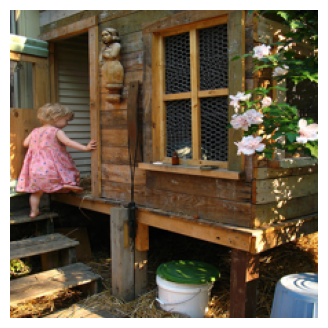

Generated Caption: a little girl climbing into a wooden playhouse.


In [20]:
def generate_caption(image, model, tokenizer, device):
    # Convert image to tensor and move it to the appropriate device
    image = torch.unsqueeze(torch.tensor(image), 0).to(device)
    
    # Encode image using the model's encoder
    encoder_output = model.encoder(pixel_values=image)
    
    # Initialize the decoder input with the special token for start of sequence
    decoder_input_ids = torch.tensor(tokenizer.encode("[CLS]")).unsqueeze(0).to(device)
    
    # Initialize the list to hold generated token IDs
    generated_ids = []
    
    # Set maximum length for generated caption
    max_length = 32
    
    # Generate tokens one by one using the decoder
    for _ in range(max_length):
        # Generate next token
        outputs = model.decoder(input_ids=decoder_input_ids, encoder_hidden_states=encoder_output.last_hidden_state)
        next_token_logits = outputs.logits[:, -1, :]
        next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
        
        # Append the token to the list of generated tokens
        generated_ids.append(next_token_id.item())
        
        # Break if the end of sequence token is generated
        if next_token_id.item() == tokenizer.sep_token_id:
            break
        
        # Prepare input for the next iteration
        decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1)
    
    # Decode the generated token IDs into a caption string
    generated_caption = tokenizer.decode(generated_ids, skip_special_tokens=True)
    
    # Display the image and print the generated caption
    image = np.moveaxis(image[0].cpu().numpy(), 0, -1)
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print("Generated Caption:", generated_caption)
    
    return generated_caption

# Example usage
pred_caption = generate_caption(
    image=train_dataset.__getitem__(0)['pixel_values'].numpy(),
    model=saved_model,
    tokenizer=decoder_tokenizer,
    device=device
)


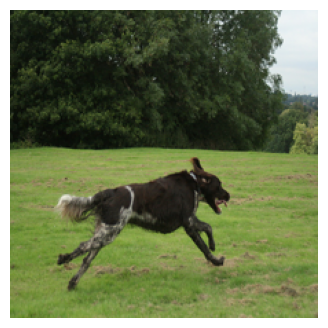

Generated Caption: a black dog runs through a field.
Time taken to generate caption: 0.3732 seconds

 



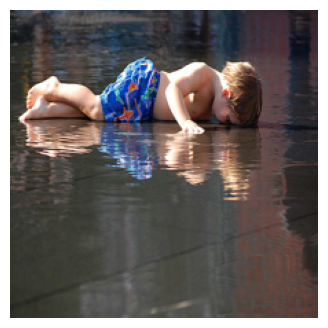

Generated Caption: a young boy laying face down in water.
Time taken to generate caption: 0.3266 seconds

 



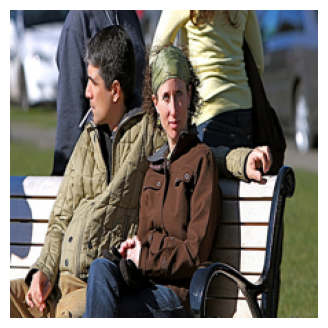

Generated Caption: a man and woman sit on a bench outdoors.
Time taken to generate caption: 0.3542 seconds

 



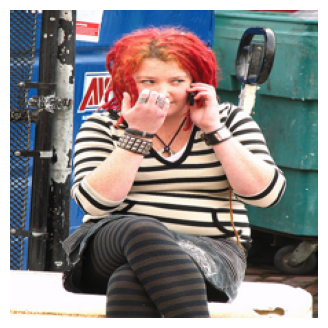

Generated Caption: a woman with bright red hair and striped clothing talks on a phone.
Time taken to generate caption: 0.4212 seconds

 



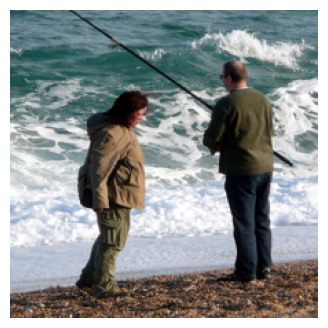

Generated Caption: a man and woman fishing at the beach.
Time taken to generate caption: 0.3313 seconds

 



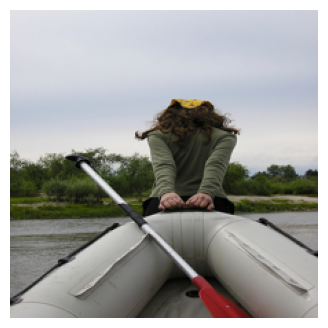

Generated Caption: a woman pulls an inflatable boat into the water.
Time taken to generate caption: 0.3691 seconds

 



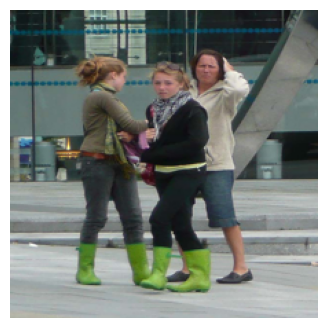

Generated Caption: two girls and a woman walking on the sidewalk
Time taken to generate caption: 0.3254 seconds

 



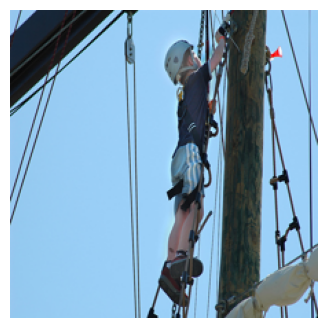

Generated Caption: a boy wearing climbing gear climbs by a wooden pole.
Time taken to generate caption: 0.3354 seconds

 



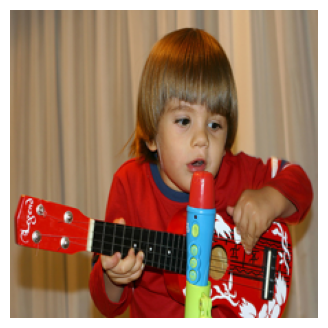

Generated Caption: a little boy is playing with a toy guitar and microphone.
Time taken to generate caption: 0.3750 seconds

 



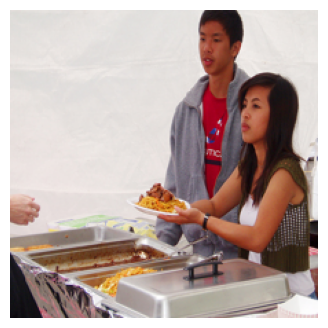

Generated Caption: girl and boy serving food on plate
Time taken to generate caption: 0.2855 seconds

 



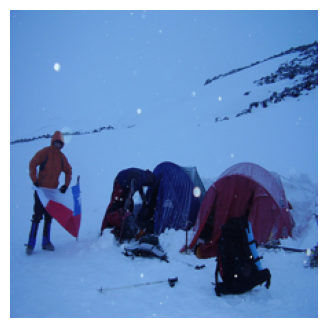

Generated Caption: mountain climbers are setting up their tents.
Time taken to generate caption: 0.3217 seconds

 



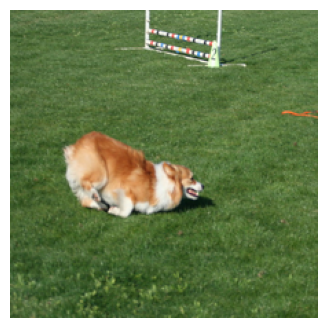

Generated Caption: a dog is crouching on the grass near a hurdle.
Time taken to generate caption: 0.3789 seconds

 



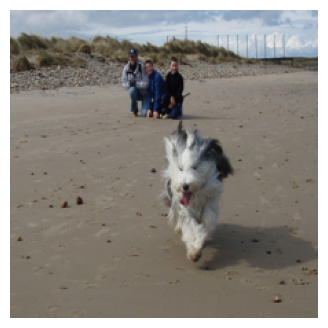

Generated Caption: a fluffy black - and - white dog runs from three people on a sandy beach.
Time taken to generate caption: 0.4661 seconds

 



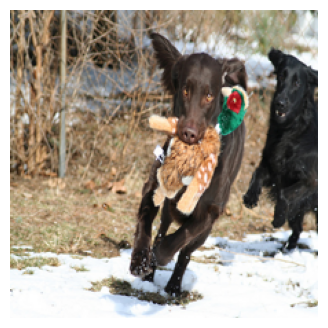

Generated Caption: a brown dig and black dog are playing with a stuffed toy.
Time taken to generate caption: 0.3756 seconds

 



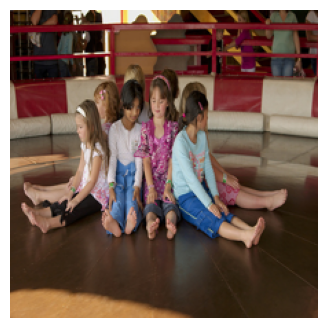

Generated Caption: little girls sitting in a circle on wooden floor surrounded by observer area.
Time taken to generate caption: 0.4102 seconds

 



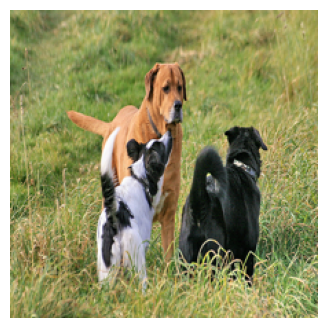

Generated Caption: the three dogs are standing in tall grass.
Time taken to generate caption: 0.3155 seconds

 



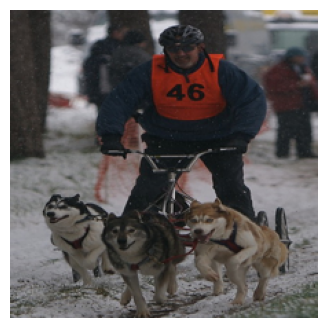

Generated Caption: three dogs pulling a man on a bicycle through the snow.
Time taken to generate caption: 0.3728 seconds

 



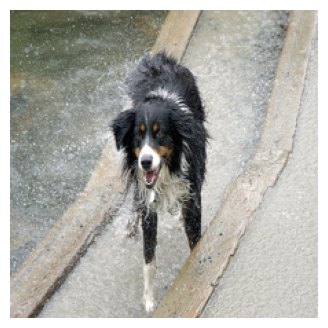

Generated Caption: a dog is shaking water off of itself.
Time taken to generate caption: 0.3222 seconds

 



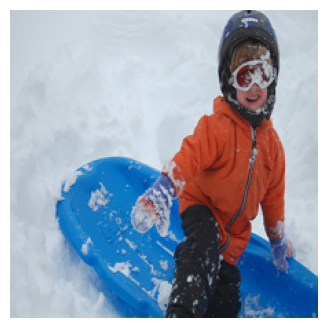

Generated Caption: a child sleds.
Time taken to generate caption: 0.2534 seconds

 



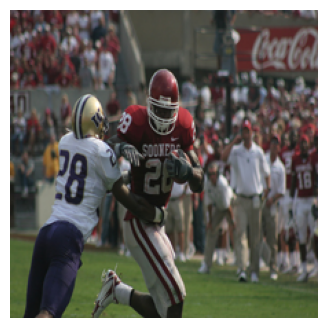

Generated Caption: the football player in white is defending against the player in red who is running with the ball.
Time taken to generate caption: 0.5056 seconds

 



In [21]:
import time

for index in np.random.randint(int(text_data_train.shape[0]/4 - 1),size=20):
    start_time = time.time()
    pred_caption = generate_caption( image=train_dataset.__getitem__(index)['pixel_values'].numpy(), model=saved_model , tokenizer=decoder_tokenizer ,
    device=device )
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken to generate caption: {elapsed_time:.4f} seconds")
    print( "\n \n" )